In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import scipy.ndimage as ndi

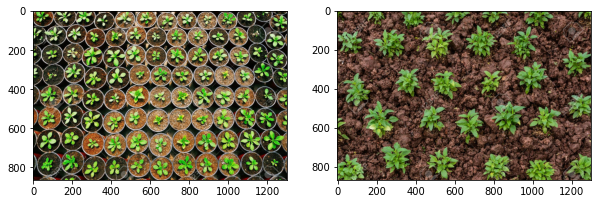

In [64]:
# load the images seedling1 and 2 from the exampleIMages folder
seedling1 = plt.imread('exampleImages/seedling1.jpg')
seedling2 = plt.imread('exampleImages/seedling2.jpg')

#display them next to each other
fig, ax = plt.subplots(1, 2, figsize=(10, 5)  ) 
ax[0].imshow(seedling1)
ax[1].imshow(seedling2)
plt.show()

In [65]:
# grab all the hsv values from the first image

seedling1_hsv = colors.rgb_to_hsv(seedling1)
seedling2_hsv = colors.rgb_to_hsv(seedling2)

# split the hsv values into their components
seedling1_h = seedling1_hsv[:,:,0]
seedling1_s = seedling1_hsv[:,:,1]
seedling1_v = seedling1_hsv[:,:,2]

seedling2_h = seedling2_hsv[:,:,0]
seedling2_s = seedling2_hsv[:,:,1]
seedling2_v = seedling2_hsv[:,:,2]

In [66]:
# create a function that takes in an image and the thresholds and returns a binary mask
def threshold_image(h, s, v, threshold_h_lower, threshold_h_upper, threshold_s_lower, threshold_s_upper, threshold_v_lower, threshold_v_upper):
    mask = np.zeros(h.shape)
    mask[(h > threshold_h_lower) & (h < threshold_h_upper) & (s > threshold_s_lower) & (s < threshold_s_upper) & (v > threshold_v_lower) & (v < threshold_v_upper)] = 1
    return mask

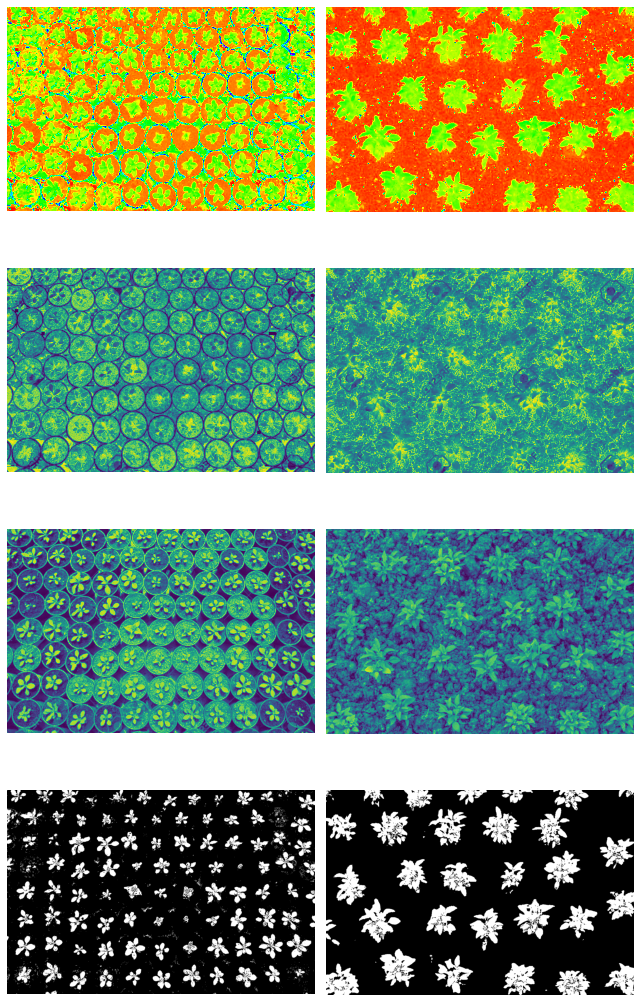

In [67]:
threshold_h_lower = 70/360
threshold_h_upper = 170/360
threshold_s_lower = 0.2
threshold_s_upper = 1.0
threshold_v_lower = 50
threshold_v_upper = 360  # no need for a threshold on the upper end of the value channel


mask1 = threshold_image(seedling1_h, seedling1_s, seedling1_v, threshold_h_lower, threshold_h_upper, threshold_s_lower, threshold_s_upper, threshold_v_lower, threshold_v_upper)
mask2 = threshold_image(seedling2_h, seedling2_s, seedling2_v, threshold_h_lower, threshold_h_upper, threshold_s_lower, threshold_s_upper, threshold_v_lower, threshold_v_upper)

fig, ax = plt.subplots(4, 2, figsize=(9, 15)  )
# show the different channels of the images
ax[0,0].imshow(seedling1_h, cmap='hsv')
ax[0,1].imshow(seedling2_h, cmap='hsv')
ax[1,0].imshow(seedling1_s)
ax[1,1].imshow(seedling2_s)
ax[2,0].imshow(seedling1_v)
ax[2,1].imshow(seedling2_v)
ax[3,0].imshow(mask1, cmap='gray')
ax[3,1].imshow(mask2, cmap='gray')

# remove the axis labels and ticks
for i in range(4):
    for j in range(2):
        ax[i,j].axis('off')

#thight layout
plt.tight_layout()
plt.show()

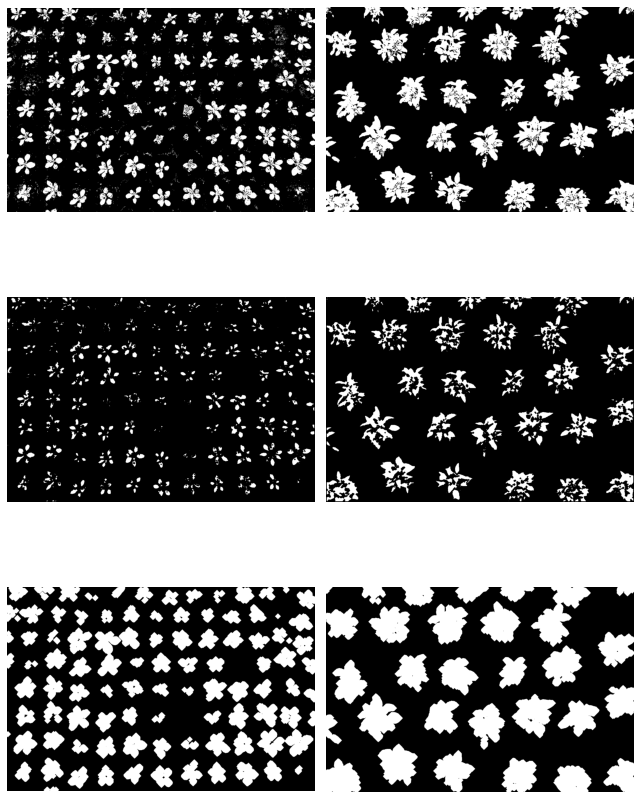

In [68]:
# erode and dilate the mask to remove small noise and fill in small holes

errosion_iterations = 3
dilation_iterations = 12


fig, ax = plt.subplots(3, 2, figsize=(9, 13)  )
# copy the mask to a new boolean variable
mask1_bool = mask1.astype(bool)
mask2_bool = mask2.astype(bool)

# display mask1_bool and mask2_bool
ax[0,0].imshow(mask1_bool, cmap='gray')
ax[0,1].imshow(mask2_bool, cmap='gray')

# use boolean errosion
mask1_eroded = ndi.binary_erosion(mask1_bool, iterations=errosion_iterations)
mask2_eroded = ndi.binary_erosion(mask2_bool, iterations=errosion_iterations)

# display the eroded masks
ax[1,0].imshow(mask1_eroded, cmap='gray')
ax[1,1].imshow(mask2_eroded, cmap='gray')


# use boolean dilation
mask1_dilated = ndi.binary_dilation(mask1_eroded, iterations=dilation_iterations)
mask2_dilated = ndi.binary_dilation(mask2_eroded, iterations=dilation_iterations)

# display the dilated masks
ax[2,0].imshow(mask1_dilated, cmap='gray')
ax[2,1].imshow(mask2_dilated, cmap='gray')

# remove the axis labels and ticks
for i in range(3):
    for j in range(2):
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()

In [69]:
# create a function that takes an image and returns the hsv values
def get_hsv(image):
    hsv = colors.rgb_to_hsv(image)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    return h, s, v

In [70]:
# create a function that takes in a mask and the number of clusters and returns the area of each cluster
def cluster_areas(mask_clusters, n_clusters):
    areas = []
    for i in range(1, n_clusters+1):
        areas.append(np.sum(mask_clusters == i))
    return areas


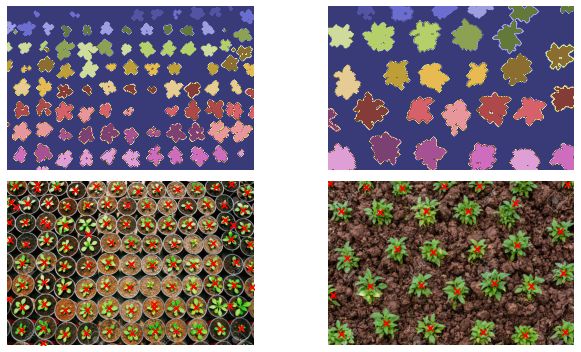

In [71]:
# cluster the mask into individual objects
mask1_clusters, mask1_n_clusters = ndi.label(mask1_dilated)
mask2_clusters, mask2_n_clusters = ndi.label(mask2_dilated)

# display the clusters
fig, ax = plt.subplots(2, 2, figsize=(10, 5)  )
ax[0,0].imshow(mask1_clusters, cmap='tab20b')
ax[0,1].imshow(mask2_clusters, cmap='tab20b')

# show the original images
ax[1,0].imshow(seedling1, alpha=1)
ax[1,1].imshow(seedling2, alpha=1)

# loop through the clusters and scatter an x at the center of each cluster
for i in range(1, mask1_n_clusters+1):
    y, x = np.where(mask1_clusters == i)
    ax[1,0].scatter(np.mean(x), np.mean(y), c='r', marker='x')

for i in range(1, mask2_n_clusters+1):
    y, x = np.where(mask2_clusters == i)
    ax[1,1].scatter(np.mean(x), np.mean(y), c='r', marker='x')


# remove the axis labels and ticks
for i in range(2):
    for j in range(2):
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()

In [74]:
# function to turn a binary mask into clusters like before
def cluster_mask(mask, errosion_iterations, dilation_iterations):
    # check if the mask is of type bool
    if mask.dtype != bool:
        mask = mask.astype(bool)
    
    mask_eroded = ndi.binary_erosion(mask, iterations=errosion_iterations)
    mask_dilated = ndi.binary_dilation(mask_eroded, iterations=dilation_iterations)
    mask_clusters, mask_n_clusters = ndi.label(mask_dilated)
    return mask_clusters, mask_n_clusters

In [79]:
# let's write a function that returns the area of each cluster and the coordinates of the center of each cluster
def cluster_areas_and_centers(mask_clusters, n_clusters):
    areas = []
    centers = []
    for i in range(1, n_clusters+1):
        y, x = np.where(mask_clusters == i)
        areas.append(len(y))
        centers.append((np.mean(x), np.mean(y)))
    return areas, centers

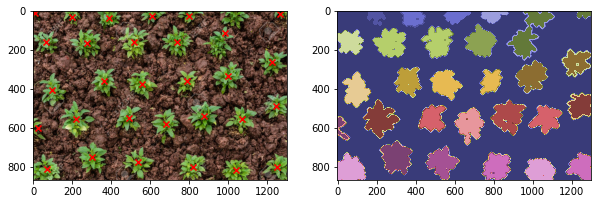

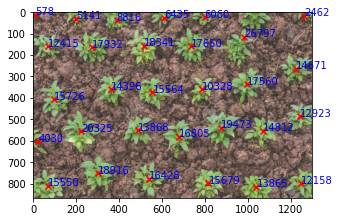

In [86]:
# usage example with the mask creation function

img = seedling2

##########################
h, s, v = get_hsv(img)
mask = threshold_image(h, s, v, threshold_h_lower, threshold_h_upper, threshold_s_lower, threshold_s_upper, threshold_v_lower, threshold_v_upper)
mask_clusters, mask_n_clusters = cluster_mask(mask, 3, 12)
areas, centers = cluster_areas_and_centers(mask_clusters, mask_n_clusters)
##########################

fig, ax = plt.subplots(1, 2, figsize=(10, 5)  )
ax[0].imshow(img)
ax[1].imshow(mask_clusters, cmap='tab20b')

# loop through the clusters and scatter an x at the center of each cluster
for i in range(1, mask_n_clusters+1):
    y, x = np.where(mask_clusters == i)
    ax[0].scatter(np.mean(x), np.mean(y), c='r', marker='x')

plt.show()

# write the areas onto the image centers
fig, ax = plt.subplots(1, 1, figsize=(5, 5)  )
ax.imshow(img, alpha= 0.8)

# loop through the clusters and scatter an x at the center of each cluster
for i in range(mask_n_clusters):
    ax.scatter(centers[i][0], centers[i][1], c='r', marker='x')
    ax.text(centers[i][0], centers[i][1], str(areas[i]), c='b')

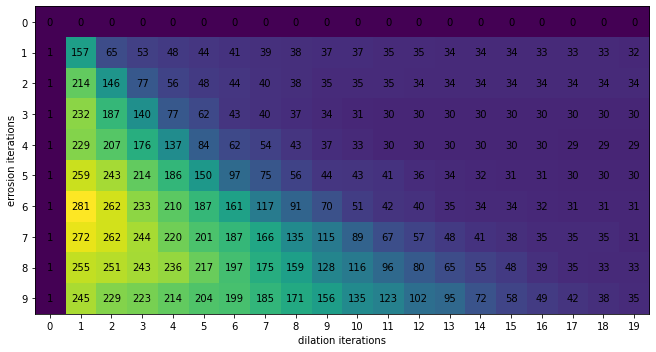

In [88]:
# count the number of total clusters for different errosion and dilation iterations
errosion_iterations = np.arange(0, 10)
dilation_iterations = np.arange(0, 20)

n_clusters = np.zeros((len(errosion_iterations), len(dilation_iterations)))

for i in range(len(errosion_iterations)):
    for j in range(len(dilation_iterations)):
        mask_clusters, mask_n_clusters = cluster_mask(mask, errosion_iterations[i], dilation_iterations[j])
        n_clusters[i,j] = mask_n_clusters

fig, ax = plt.subplots(1, 1, figsize=(10, 5)  )
ax.imshow(n_clusters, cmap='viridis')
ax.set_xlabel('dilation iterations')
ax.set_ylabel('errosion iterations')
ax.set_xticks(np.arange(len(dilation_iterations)))
ax.set_xticklabels(dilation_iterations)
ax.set_yticks(np.arange(len(errosion_iterations)))
ax.set_yticklabels(errosion_iterations)
# add the number of clusters to each cell
for i in range(len(errosion_iterations)):
    for j in range(len(dilation_iterations)):
        ax.text(j, i, str(int(n_clusters[i,j])), ha='center', va='center', color='black')
fig.tight_layout()
plt.show()


# calculate the derivative of the area with respect to the number of errosion and dilation iterations
n_clusters_x, n_clusters_y = np.gradient(n_clusters)

fig, ax = plt.subplots(1, 1, figsize=(10, 5)  )
ax.imshow(n_clusters_x)
ax.set_xlabel('dilation iterations')
ax.set_ylabel('errosion iterations')
ax.set_xticks(np.arange(len(dilation_iterations)))
ax.set_xticklabels(dilation_iterations)
ax.set_yticks(np.arange(len(errosion_iterations)))
ax.set_yticklabels(errosion_iterations)
fig.tight_layout()
# colorbar
cbar = plt.colorbar(ax.imshow(n_clusters_x))
cbar.set_label('derivative of number of clusters with respect to dilation iterations')
plt.show()


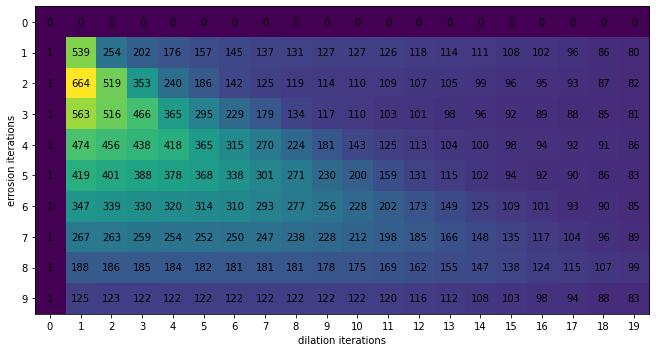

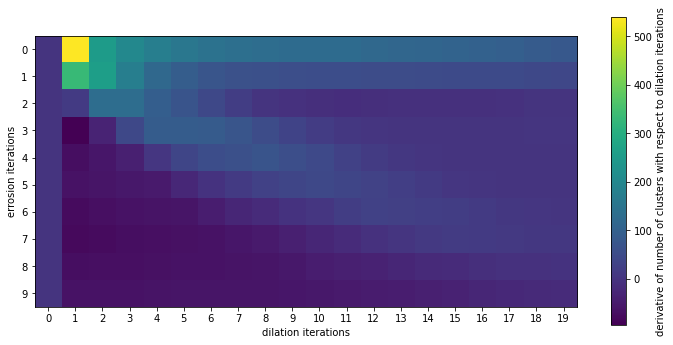

In [93]:
# count the number of total clusters for different errosion and dilation iterations
errosion_iterations = np.arange(0, 10)
dilation_iterations = np.arange(0, 20)


img = seedling1
mask = threshold_image(*get_hsv(img), threshold_h_lower, threshold_h_upper, threshold_s_lower, threshold_s_upper, threshold_v_lower, threshold_v_upper)

n_clusters = np.zeros((len(errosion_iterations), len(dilation_iterations)))

for i in range(len(errosion_iterations)):
    for j in range(len(dilation_iterations)):
        mask_clusters, mask_n_clusters = cluster_mask(mask, errosion_iterations[i], dilation_iterations[j])
        n_clusters[i,j] = mask_n_clusters

fig, ax = plt.subplots(1, 1, figsize=(10, 5)  )
ax.imshow(n_clusters, cmap='viridis')
ax.set_xlabel('dilation iterations')
ax.set_ylabel('errosion iterations')
ax.set_xticks(np.arange(len(dilation_iterations)))
ax.set_xticklabels(dilation_iterations)
ax.set_yticks(np.arange(len(errosion_iterations)))
ax.set_yticklabels(errosion_iterations)
# add the number of clusters to each cell
for i in range(len(errosion_iterations)):
    for j in range(len(dilation_iterations)):
        ax.text(j, i, str(int(n_clusters[i,j])), ha='center', va='center', color='black')
fig.tight_layout()
plt.show()


# calculate the derivative of the area with respect to the number of errosion and dilation iterations
n_clusters_x, n_clusters_y = np.gradient(n_clusters)

fig, ax = plt.subplots(1, 1, figsize=(10, 5)  )
ax.imshow(n_clusters_x)
ax.set_xlabel('dilation iterations')
ax.set_ylabel('errosion iterations')
ax.set_xticks(np.arange(len(dilation_iterations)))
ax.set_xticklabels(dilation_iterations)
ax.set_yticks(np.arange(len(errosion_iterations)))
ax.set_yticklabels(errosion_iterations)
fig.tight_layout()
# colorbar
cbar = plt.colorbar(ax.imshow(n_clusters_x))
cbar.set_label('derivative of number of clusters with respect to dilation iterations')
plt.show()
